In [2]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
import pickle

In [3]:
import sys
sys.path.append('../')

In [4]:
import helper

In [5]:
datafile = '../Data/Enzyme_Dataset.txt'

In [6]:
X,y,enznames = helper.parseEnzymeFile(datafile)

In [7]:
savedmodel = 'AEmodel.sav'

reg = pickle.load(open(savedmodel,'rb'))

In [8]:
# get all possible AAs for all enzymes

AAvalset = set()

for x in X:
    AAvalset.update(set(x))

AAvalset.add('-')

testAA  = sorted(AAvalset)

# Grouping the set according to their physicochemical characteristics

GAAset = {'G':'g1','A':'g1','V':'g1','L':'g1','M':'g1','I':'g1','F':'g2','Y':'g2','W':'g2',
                       'K':'g3','R':'g3','H':'g3', 'D':'g4', 'E':'g4','S':'g5','T':'g5','C':'g5','P':'g5',
                       'N':'g5','Q':'g5','X':'g6','-':'g6'}

# Create a one hot encoded array for AAs with their groups specified

OHEdict = {aa:num for aa, num in zip(testAA,range(len(testAA)))}

GAAlist = sorted(set(GAAset.values()))
GAAnum = range(len(OHEdict),len(OHEdict)+len(GAAlist))

for gaa,gnum in zip(GAAlist,GAAnum):
    OHEdict[gaa] = gnum
    
def get_OHE_val(aa):
    ohe = [0 for i in range(len(OHEdict))]
    ohe[OHEdict[aa]] = 1
    ohe[OHEdict[GAAset[aa]]] = 1
    return ohe

Xtest = np.array(list(map(get_OHE_val,testAA)))

In [9]:
AApred = reg.predict(Xtest)

In [10]:
enzdatafile = '../Data/Enzyme_aligned.txt'
X_aligned,y,enznames = helper.parseEnzymeFile(enzdatafile)

In [11]:
def tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def encode(x,layer):
    linear_layer = x*reg.coefs_[layer] + reg.intercepts_[layer]
    activation = tanh(linear_layer)
    return activation
    
    

def encoder(data,nlayers):
    data = np.asmatrix(data)
    
    encoder = data
    
    for i in range(nlayers):
        encoder = encode(encoder,i)
    
    latent = encode(encoder,nlayers)
    
    return np.asarray(latent)

In [12]:
AA2Contdict = dict(zip(testAA,np.ravel(encoder(Xtest,6))))

In [13]:
def autoencode(seq):
    x_autoencoded = []
    for aa in seq:
        x_autoencoded.append(AA2Contdict[aa])
    
    return np.array(x_autoencoded)
        

X_autoencoded = np.array(list(map(autoencode,X_aligned)))

In [14]:
y_enc = np.array(y)

In [328]:
X_autoencoded

array([[-0.04855965, -0.04855965, -0.04855965, ..., -0.04855965,
        -0.04855965, -0.04855965],
       [-0.04855965, -0.04855965, -0.04855965, ..., -0.04855965,
        -0.04855965, -0.04855965],
       [-0.04855965, -0.04855965, -0.04855965, ..., -0.04855965,
        -0.04855965, -0.04855965],
       ...,
       [-0.04855965, -0.04855965,  0.37521005, ..., -0.04855965,
        -0.04855965, -0.04855965],
       [-0.04855965, -0.04855965,  0.37521005, ..., -0.04855965,
        -0.04855965, -0.04855965],
       [-0.04855965, -0.04855965,  0.37521005, ..., -0.04855965,
        -0.04855965, -0.04855965]])

In [16]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [17]:
def balancing_function(X_tr,y_tr):
    values,counts = np.unique(y_tr,return_counts=True)
    label_count_dict = {l:c for l,c in zip(values,counts)}
    
    # get the max count
    max_count = max(label_count_dict.values())
    
    # for the labels with less max count, randomly select their index and append that index to the array
    
    for k,v in label_count_dict.items():
        if v<max_count:
            #get the indices with those values
            indices = np.where(y_tr==k)[0]
            
            # get how training set must be duplicated
            n_duplicate = max_count-v
            
            if n_duplicate>v:
                
                times_to_add = n_duplicate//v 
                    
                X_tr_k = X_tr[indices,:]
                
                for i in range(times_to_add):
                    X_tr = np.concatenate((X_tr,X_tr_k),axis=0)
                    y_tr = np.append(y_tr,np.array([k for i in range(v)]))
                
                remaining_times = n_duplicate-times_to_add*v
                
                random_indices = np.random.choice(indices,size=remaining_times)
                
                X_tr_extra = X_tr[random_indices,:]
                y_tr_extra = np.array([k for i in range(remaining_times)])
                
                X_tr = np.concatenate((X_tr,X_tr_extra),axis=0)
                y_tr = np.append(y_tr,y_tr_extra)
                
            else:
                
                remaining_times = n_duplicate
                
                random_indices = np.random.choice(indices,size=remaining_times)
                
                X_tr_extra = X_tr[random_indices,:]
                y_tr_extra = np.array([k for i in range(remaining_times)])
                
                X_tr = np.concatenate((X_tr,X_tr_extra),axis=0)
                y_tr = np.append(y_tr,y_tr_extra)
                
                
    return X_tr,y_tr

In [52]:
tracc = []
teacc = []
tepreds = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_autoencoded, y_enc, test_size=0.25, random_state=i)

    X_train,y_train = balancing_function(X_train,y_train)

    
    steps = [('SVM',SVC(C=100,gamma='scale',kernel='rbf'))]
#     steps = [('pca',PCA(n_components=45)),('SVM',SVC(C=100,gamma='scale',kernel='rbf'))]
    pipe = Pipeline(steps)
    pipe.fit(X_train,y_train)
    ypredtrain = pipe.predict(X_train)
    ypredtest = pipe.predict(X_test)
    tepreds.append(ypredtest)
    trainacc = accuracy_score(y_train,ypredtrain)
    testacc = accuracy_score(y_test,ypredtest)
    tracc.append(trainacc)
    teacc.append(testacc)
    if i%10==0:
        print(i)

0
10
20
30
40
50
60
70
80
90


In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

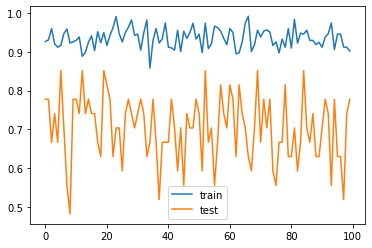

In [54]:
plt.plot(tracc,label='train')
plt.plot(teacc,label='test')
plt.legend()

In [55]:
np.argmin(teacc),np.argmax(teacc)

(8, 5)

In [56]:
np.mean(teacc),np.mean(tracc)

(0.702962962962963, 0.9357133849296937)

In [57]:
min(teacc),max(teacc)

(0.48148148148148145, 0.8518518518518519)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_autoencoded, y_enc, test_size=0.33, random_state=97)

In [60]:
np.unique(y_test,return_counts=True)

(array([1, 2, 3]), array([14,  7, 14]))

In [61]:
np.unique(y_train,return_counts=True)

(array([1, 2, 3]), array([23, 11, 37]))

In [62]:
tepreds[97]

array([1, 1, 1, 2, 1, 3, 2, 2, 3, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 3, 1,
       1, 1, 3, 3, 2])

In [63]:
y_test

array([2, 1, 2, 2, 2, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 2, 1, 3, 1, 1, 3,
       1, 1, 3, 3, 2, 1, 2, 1, 3, 3, 3, 3, 3])

In [92]:
X,y,enzname = [],[],[]
with open('../Data/RegressionData.txt','r') as f:
    for lines in f:
        data = lines.strip().split(',')
        X.append(data[1])
        y.append(float(data[2]))
        enzname.append(data[0])
    

In [93]:
X,y,enzname = np.array(X),np.array(y),np.array(enzname)

In [94]:
X_aligned.shape

(106,)

In [95]:
X_autoencoded = np.array(list(map(autoencode,X_aligned)))

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
def get_model(n_comp):
    steps = [('pca',PCA(n_components=n_comp)),('LR',LinearRegression())]
    pipe = Pipeline(steps)
    return pipe
    

In [97]:
teidx,tridx = helper.modified_split(enzname)

X_tr,y_tr = X_autoencoded[tridx],y[tridx]

In [98]:
mypipe = get_model(40)

model = mypipe.fit(X_tr,y_tr)

In [99]:
X_te,y_te = X_autoencoded[teidx],y[teidx]

In [100]:
y_pred_te = model.predict(X_te)

In [101]:
y_te

array([0.15      , 0.00791766, 0.854     , 0.23      , 0.602     ,
       0.542     , 0.98      , 0.704     , 0.799     , 0.669     ,
       0.587     , 0.897     , 0.683     , 0.57091562, 0.596     ,
       0.824     , 0.01383399, 0.24      , 0.867     , 0.        ,
       0.61      , 0.09      , 0.697     , 0.604     ])

In [102]:
y_pred_te

array([ 0.47581434,  0.25561496,  0.53029086,  0.24538591,  0.64052465,
        0.24110674, -0.31999969,  0.37589835,  0.63029531,  0.27175563,
        0.62205958,  0.67504655,  0.53255151,  0.32746434,  0.59835506,
        0.64449348,  0.01582818,  0.31401924,  0.12632722,  0.51799187,
        0.6686221 , -0.09852402,  0.60902984,  0.41047915])

In [103]:
from sklearn.metrics import mean_squared_error

In [104]:
mean_squared_error(y_te,y_pred_te)

0.14248557726490482